In [116]:
# from IPython.display import HTML

# HTML('''<script>
# code_show=true;
# function code_toggle() {
# if (code_show){
# $('div.input').hide();
# } else {
# $('div.input').show();
# }
# code_show = !code_show
# }
# $( document ).ready(code_toggle);
# </script>
# The code for this notebook is hidden for easier reading.
# To toggle it on/off, please click <a href="javascript:code_toggle()">here</a>.''')

In [117]:
%matplotlib inline
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sklearn
import seaborn as sns
from sklearn import linear_model
from sklearn import metrics
from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Data Cleaning

**Data: Crime In New York - [2013](https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv).**

# Notes: Session With Joe

**I was told to Z-normalize the entire dataset, then build functions that iteratively drop features in a backward pass and calculate train/test/validation scores so that I can:** 
-  Select the optimal number of features for building my Linear Regression model, check assumptions, tune parameters, finalize the model, and evaluate its performance.
-  Select the optimal k for building my weighted/unweighted k-NN Regression models and then the optimal number of features, finalize the model, and evaluate its performance.  

**As such, my questions are:**
-  How come R^2 is 100% when the number of features is greater than or equal to 7? What does that mean for feature selection? Was my initial workflow (re: other notebook) wrong? If so, why? 
- How do I select the optimal k when it differs for training/testing/cross-validation? How would I tell if my model was overfitting? 
-  What do I fix about my other two functions to resolve dimension-related errors?

In [118]:
path = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'
crime = pd.read_csv(path)

In [119]:
pd.options.mode.chained_assignment = None

crime.columns = ['city','population','violent_crime','murder','rape_revised','rape_legacy','robbery','aggravated_assault','property_crime','burglary','larceny_theft','vehicle_theft','arson']
crime.drop(labels=[0,1,2,3,352,353,354],axis=0,inplace=True)
crime.drop(labels=['city','rape_revised'],axis=1,inplace=True)

columns = list(crime.columns)
for column in columns:
     crime[column]=crime[column].str.replace(',','')

crime = crime.apply(pd.to_numeric)
crime = crime.dropna()

In [120]:
crime.head()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
4,1861,0,0,0,0,0,12,2,10,0,0.0
5,2577,3,0,0,0,3,24,3,20,1,0.0
6,2846,3,0,0,0,3,16,1,15,0,0.0
10,1781,3,0,0,0,3,10,0,10,0,0.0
11,118296,107,1,7,31,68,2118,204,1882,32,3.0


In [121]:
crime.describe()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,14787.053476,45.978610,0.566845,2.192513,16.556150,26.663102,339.823529,65.037433,260.871658,13.914439,1.871658
std,27220.701187,201.362989,3.552914,9.124901,81.476501,109.234772,965.182269,242.693164,675.898585,57.360520,10.693411
min,526.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2195.000000,1.000000,0.000000,0.000000,0.000000,0.000000,19.500000,3.000000,16.000000,0.000000,0.000000
50%,6487.000000,4.000000,0.000000,0.000000,1.000000,3.000000,73.000000,11.000000,62.000000,2.000000,0.000000
75%,16109.000000,17.000000,0.000000,1.000000,4.000000,11.000000,297.000000,39.000000,240.500000,5.000000,1.000000
max,210562.000000,2107.000000,42.000000,92.000000,918.000000,1055.000000,10051.000000,2587.000000,6855.000000,609.000000,132.000000


In [122]:
z_scaler = StandardScaler()
crime = pd.DataFrame(data=z_scaler.fit_transform(crime),
                   columns=['aggravated_assault','arson','burglary','larceny_theft','murder','population','property_crime','rape_legacy','robbery','vehicle_theft','violent_crime'])

In [123]:
crime.head()

,aggravated_assault,arson,burglary,larceny_theft,murder,population,property_crime,rape_legacy,robbery,vehicle_theft,violent_crime
0,-0.476136,-0.228950,-0.159972,-0.240923,-0.203747,-0.244745,-0.340561,-0.260439,-0.372164,-0.243230,-0.175499
1,-0.449762,-0.214011,-0.159972,-0.240923,-0.203747,-0.217208,-0.328095,-0.256307,-0.357329,-0.225749,-0.175499
2,-0.439853,-0.214011,-0.159972,-0.240923,-0.203747,-0.217208,-0.336406,-0.264570,-0.364747,-0.243230,-0.175499
3,-0.479083,-0.214011,-0.159972,-0.240923,-0.203747,-0.217208,-0.342639,-0.268702,-0.372164,-0.243230,-0.175499
4,3.812790,0.303855,0.122243,0.528268,0.177752,0.379438,1.847268,0.574123,2.404918,0.316143,0.105801


In [124]:
crime.describe()

,aggravated_assault,arson,burglary,larceny_theft,murder,population,property_crime,rape_legacy,robbery,vehicle_theft,violent_crime
count,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02,1.870000e+02
mean,3.799694e-17,8.074349e-17,3.241614e-16,2.541045e-16,-1.899847e-17,1.947343e-16,9.499234e-18,4.274655e-17,-1.662366e-17,1.187404e-16,1.139908e-16
std,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00,1.002685e+00
min,-5.253112e-01,-2.289499e-01,-1.599720e-01,-2.409231e-01,-2.037470e-01,-2.447451e-01,-3.530274e-01,-2.687016e-01,-3.869989e-01,-2.432299e-01,-1.754990e-01
25%,-4.638329e-01,-2.239704e-01,-1.599720e-01,-2.409231e-01,-2.037470e-01,-2.447451e-01,-3.327697e-01,-2.563071e-01,-3.632631e-01,-2.432299e-01,-1.754990e-01
50%,-3.057355e-01,-2.090320e-01,-1.599720e-01,-2.409231e-01,-1.914406e-01,-2.172076e-01,-2.771910e-01,-2.232552e-01,-2.950229e-01,-2.082691e-01,-1.754990e-01
75%,4.869439e-02,-1.442986e-01,-1.599720e-01,-1.310387e-01,-1.545213e-01,-1.437743e-01,-4.448744e-02,-1.075734e-01,-3.022102e-02,-1.558279e-01,-8.173237e-02
max,7.211442e+00,1.026283e+01,1.169305e+01,9.868445e+00,1.109355e+01,9.439279e+00,1.008851e+01,1.041947e+01,9.782282e+00,1.040233e+01,1.220169e+01


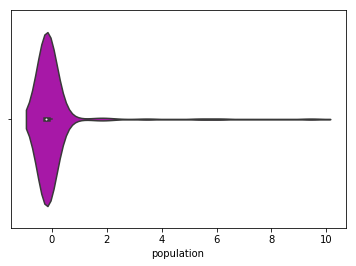

In [125]:
population = sns.violinplot(crime['population'], color='m')

In [126]:
q25 = crime['population'].quantile(0.25)
q75 = crime['population'].quantile(0.75)
iqr = q75 - q25
maximum = q75 + (iqr * 1.5)
crime=crime.where(crime['population'] < maximum)

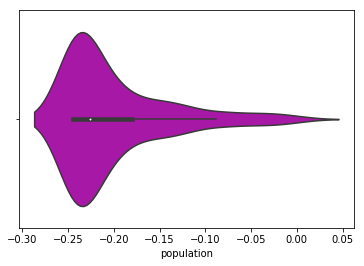

In [127]:
population = sns.violinplot(crime['population'], color='m')

# Linear Regression Model 

In [128]:
crime = crime.replace([np.inf, -np.inf], np.nan).dropna(how="all")

In [129]:
def iterative_LR(X,Y):
    
    features = list(X.columns) 
    feature_count = []
    train_scores = []
    test_scores = []
    cross_scores = []
    
    for i in range(len(features),0,-1):  
        feature_count.append(i)
        X = X[features[:i+1]]
                
        #Train-Test Split.
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.9, random_state=0)
        
        #Training & Scores.
        regr = linear_model.LinearRegression()
        regr.fit(X_train,Y_train)
        train_scores.append(regr.score(X_train, Y_train)*100)
               
        #Testing & Scores.
        Y_pred = regr.predict(X_test)
        test_scores.append(metrics.r2_score(Y_test, Y_pred)*100)
        
        #Cross-Validation & Scores.
        cross_scores.append(cross_val_score(regr, X_test, Y_test, cv=5, scoring = 'r2').mean()*100)
        
        #Plotting Number of Features & All 3 Scores For Each Loop Run.
        plt.plot(feature_count, train_scores, linewidth=2.0,c='k',label='Training')
        plt.plot(feature_count, test_scores, linewidth=2.0,c='c',label='Testing')  
        plt.plot(feature_count, cross_scores, linewidth=2.0,c='m',label='Cross-Validation')
        
        plt.xticks(range(12))
        plt.xlabel('Number of Features')
        plt.ylabel('Score')

    #Model Descriptive Statistics.
    maxtrainscore_idx = train_scores.index(max(train_scores))
    maxfeatures_train = feature_count[maxtrainscore_idx] 
    print('Highest Training R^2: {:.2f}%.'.format(max(train_scores)))
    print('Number Of Features For Highest Training R^2: {}.'.format(maxfeatures_train))
    
    maxtestscore_idx = test_scores.index(max(test_scores))
    maxfeatures_test = feature_count[maxtestscore_idx] 
    print('Highest Testing R^2: {:.2f}%.'.format(max(test_scores)))
    print('Number Of Features For Highest Testing R^2: {}.'.format(maxfeatures_test))
    
    maxcrossscore_idx = cross_scores.index(max(cross_scores))
    maxfeatures_cross = feature_count[maxcrossscore_idx] 
    print('Highest Cross-Validation R^2: {:.2f}%.'.format(max(cross_scores)))
    print('Number Of Features For Highest Cross-Validation R^2: {}.'.format(maxfeatures_cross))

Highest Training R^2: 100.00%.
Number Of Features For Highest Training R^2: 10.
Highest Testing R^2: 100.00%.
Number Of Features For Highest Testing R^2: 10.
Highest Cross-Validation R^2: 100.00%.
Number Of Features For Highest Cross-Validation R^2: 10.


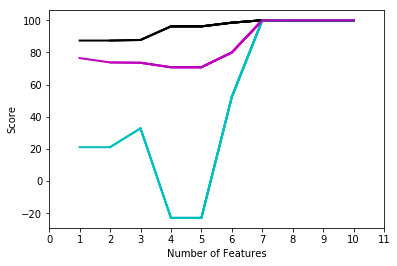

In [130]:
X = crime.drop('property_crime',axis=1)
Y = crime['property_crime']
iterative_LR(X,Y)

In [131]:
# crime_train = pd.concat([X_train, Y_train], axis=1)
# lf = 'property_crime ~ aggravated_assault + arson + burglary + larceny_theft + murder + population + rape_legacy + vehicle_theft + violent_crime'
# lm = smf.ols(formula=lf, data=crime_train).fit()
# print(lm.summary())

## Checking Assumptions

### Linear Relationship

In [132]:
# plt.scatter(y=crime['property_crime'], x=crime['burglary'], c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Burglary')
# plt.title('Burglary vs. Property Crime')
# plt.show()

# plt.scatter(y=crime['property_crime'], x=crime['larceny_theft'],c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Larceny')
# plt.title('Larceny vs. Property Crime')
# plt.show()

# plt.scatter(y=crime['property_crime'], x=crime['population'],c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Population')
# plt.title('Population vs. Property Crime')
# plt.show()

# plt.scatter(y=crime['property_crime'], x=crime['vehicle_theft'],c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Vehicle Theft')
# plt.title('Vehicle Theft vs. Property Crime')
# plt.show()

### Multivariate Normality

In [133]:
# predicted = regr.predict(X_train).ravel()
# actual = Y_train
# residual = actual - predicted

# plt.hist(residual,color='m',edgecolor='k')
# plt.title('Residual Counts')
# plt.xlabel('Residual')
# plt.ylabel('Count')
# plt.show()

### Homoscedasticity

In [134]:
# plt.scatter(predicted, residual,c='m',edgecolors='k')
# plt.xlabel('Predicted')
# plt.ylabel('Residual')
# plt.axhline(y=0,c='k')
# plt.title('Residual vs. Predicted')
# plt.show()

### Low Multicollinearity

In [135]:
# correlation_matrix = X_train.corr()
# multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
# ticks = plt.xticks(rotation=90) 

## Finalizing the Model

## Rechecking Assumptions

### Linear Relationship

In [136]:
# plt.scatter(y=crime['property_crime'], x=crime['population'],c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Population')
# plt.title('Population vs. Property Crime')
# plt.show()

# plt.scatter(y=crime['property_crime'], x=crime['burglary_theft'],c='m',edgecolors='k')
# plt.ylabel('Property Crime')
# plt.xlabel('Burglary & Theft')
# plt.title('Burglary & Theft vs. Property Crime')
# plt.show()

### Multivariate Normality

In [137]:
# predicted = regr.predict(X_train).ravel()
# actual = Y_train
# residual = actual - predicted

# plt.hist(residual,color='m',edgecolor='k')
# plt.title('Residual Counts')
# plt.xlabel('Residual')
# plt.ylabel('Count')
# plt.show()

### Homoscedasticity

In [138]:
# plt.scatter(predicted, residual,c='m',edgecolors='k')
# plt.xlabel('Predicted')
# plt.ylabel('Residual')
# plt.axhline(y=0,c='k')
# plt.title('Residual vs. Predicted')
# plt.show()

### Low Multicollinearity

In [139]:
# correlation_matrix = X_train.corr()
# multicollinearity = sns.heatmap(correlation_matrix, cmap=sns.cubehelix_palette(light=1, as_cmap=True))
# ticks = plt.xticks(rotation=90) 

## In-Sample Evaluation Against Test Split

In [140]:
# regr = linear_model.LinearRegression()
# Y_pred = regr.predict(X_test)
# print("Coefficient of Determination: {:.2f}%.".format(regr.score(X_test,Y_pred)*100))

## Cross-Validation

In [141]:
# regr = linear_model.LinearRegression()
# scores = cross_val_score(regr, X_test, Y_test, cv=5, scoring = 'r2')
# print("Cross-Validation R^2 By Fold: {}.".format(scores))
# print("Cross-Validation R^2: {:.2f}% (+/- {:.2f}%).".format(scores.mean()*100, scores.std() * 200))

# KNN Regression Models: Weighted & Unweighted

In [142]:
def KNN(X,Y,use_weights):
    Y = Y.values.reshape(-1,1)
    k_values = []
    train_scores = []
    test_scores = []
    cross_scores = []
    for k in range(1,21):
        k_values.append(k)
        
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=0)
        
        if use_weights == 1:
            knn_w = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
            knn_w.fit(X_train, Y_train)
            train_scores.append(knn_w.score(X_train,Y_train))
            Y_pred = knn_w.predict(X_test)
            test_scores.append(knn_w.score(Y_test, Y_pred)*100)
            cross_scores.append(cross_val_score(knn_w, X, Y, cv=5).mean()*100)
        else: 
            knn = neighbors.KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train,Y_train)
            train_scores.append(knn.score(X_train, Y_train)*100)
            Y_pred = knn.predict(X_test)
            test_scores.append(knn.score(Y_test, Y_pred)*100)
            cross_scores.append(cross_val_score(knn, X, Y, cv=5).mean()*100)  
    
    plt.plot(k_values, train_scores, linewidth=2.0,c='k',label='Training')
    plt.plot(k_values, test_scores, linewidth=2.0,c='c',label='Testing')
    plt.plot(k_values, cross_scores, linewidth=2.0,c='m',label='Cross-Validation')
    
    plt.xticks(range(21))
    plt.xlabel('K')
    plt.ylabel('Score')
    plt.legend()
    
    maxtrainscore_idx = train_scores.index(max(train_scores))
    maxk_train = k_values[maxtrainscore_idx] 
    print('Highest Training R^2: {:.2f}%.'.format(max(train_scores)))
    print('K For Highest Training R^2: {}.'.format(maxk_train))
    
    maxtestscore_idx = test_scores.index(max(test_scores))
    maxk_test = k_values[maxtestscore_idx] 
    print('Highest Testing R^2: {:.2f}%.'.format(max(test_scores)))
    print('K For Highest Testing R^2: {}.'.format(maxk_test))
    
    maxcrossscore_idx = cross_scores.index(max(cross_scores))
    maxk_cross = k_values[maxcrossscore_idx] 
    print('Highest Cross-Validation R^2: {:.2f}%.'.format(max(cross_scores)))
    print('K For Highest Cross-Validation R^2: {}.'.format(maxk_cross))

In [143]:
# X=crime[crime.columns]
# Y=crime['property_crime']
# use_weights=0
# KNN(X,Y,use_weights)

In [144]:
# X=crime[crime.columns]
# Y=crime['property_crime']
# use_weights=1
# KNN(X,Y,use_weights)

In [145]:
def iterative_KNN(X,Y,k,use_weights):
    
    features = list(X.columns)
#     
    t = np.arange(0, 17.2, .1)[:, np.newaxis]
        
    for i in range(len(features),0,-1):  
        X = X[features[:i+1]]
        T = np.column_stack([t]*i)
        
        if use_weights == 1:
            knn_w = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance')
            knn_w.fit(X, Y)
            Y_pred = knn_w.predict(T)
            score_w = cross_val_score(knn_w, X, Y, cv=5)
            
            plt.figure(figsize=(10,10))
            plt.scatter(X, Y, color ='k', label='Data')
            plt.plot(T, Y_pred, color ='m', label='Prediction')
            plt.legend()
            plt.ylabel('Property Crime')
            plt.xlabel(list(X.columns))
            plt.title('Weighted')
            plt.show()
            
            print("Weighted R^2: {:.2f}% (+/- {:.2f})%.".format(score_w.mean()*100, score_w.std()*100))

        else: 
            knn = neighbors.KNeighborsRegressor(n_neighbors=k)
            knn.fit(X_train,Y_train)
            Y_pred = knn.predict(T)
            score = cross_val_score(knn, X, Y, cv=5)
                         
            plt.figure(figsize=(10,10))
            plt.scatter(X, Y, color ='k', label='Data')
            plt.plot(T, Y_pred, color ='m', label='Prediction')
            plt.legend()
            plt.ylabel('Property Crime')
            plt.xlabel(list(X.columns))
            plt.title('Unweighted')
            plt.show()
            
            print("Unweighted R^2: {:.2f}% (+/- {:.2f})%.".format(score.mean()*100, score.std()*100))

In [146]:
# X=crime.drop('property_crime',axis=1)
# Y=crime['property_crime']
# k=15
# use_weights=0
# iterative_KNN(X,Y,k,use_weights)

In [147]:
# X=crime.drop('property_crime',axis=1)
# Y=crime['property_crime']
# k=15
# use_weights=1
# iterative_KNN(X,Y,k,use_weights)

# Discussion